# Black Jack Q-learning

The Q Learning as a TD algorithm
$$
\bar{q_t} = r_{t+1} + \gamma \max_a q_t(s_{t+1}, a)
$$

$$
q_{t+1} - q_{t} = \alpha (\bar{q_t} - q_t)
$$

In [4]:
from collections import defaultdict
import gymnasium as gym
import numpy as np


class BlackjackAgent:
    def __init__(
        self,
        env: gym.Env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            env: The training environment
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.env = env
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

## Section 02: Training the agent

In [5]:
# hyperparameters
learning_rate = 0.01
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

env = gym.make("Blackjack-v1", sab=False)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

agent = BlackjackAgent(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [6]:
from tqdm import tqdm

for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

100%|██████████| 100000/100000 [00:11<00:00, 9078.41it/s]


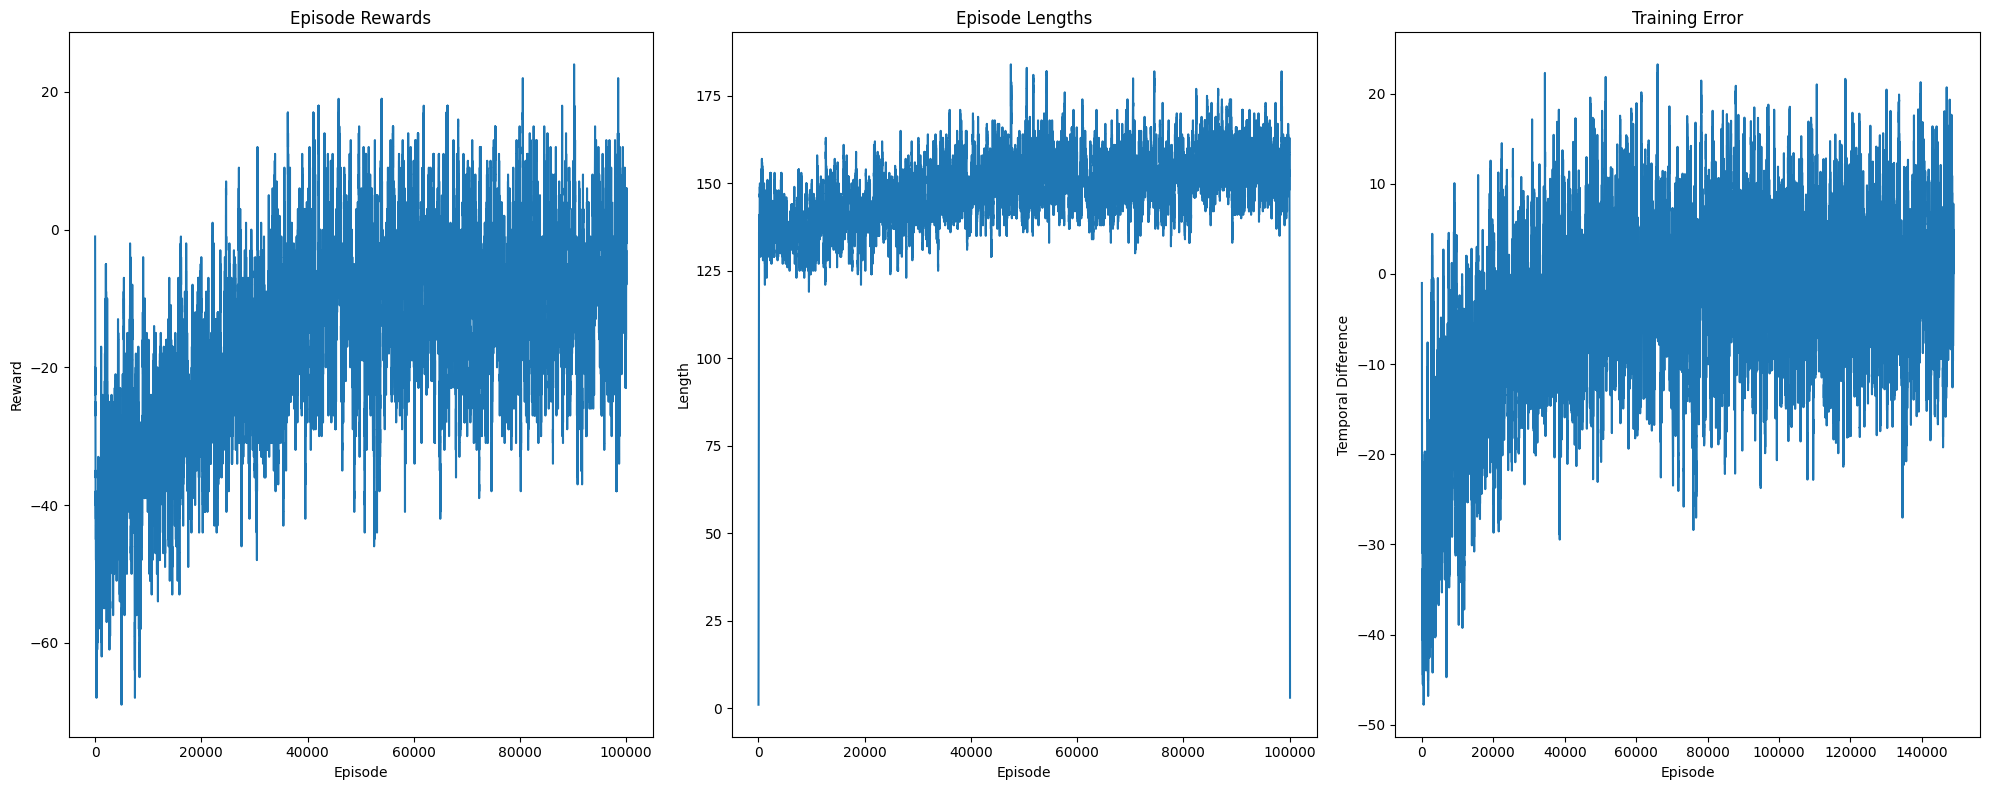

In [7]:
from matplotlib import pyplot as plt
# visualize the episode rewards, episode length and training error in one figure
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

# np.convolve will compute the rolling mean for 100 episodes

axs[0].plot(np.convolve(env.return_queue, np.ones(100)))
axs[0].set_title("Episode Rewards")
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Reward")

axs[1].plot(np.convolve(env.length_queue, np.ones(100)))
axs[1].set_title("Episode Lengths")
axs[1].set_xlabel("Episode")
axs[1].set_ylabel("Length")

axs[2].plot(np.convolve(agent.training_error, np.ones(100)))
axs[2].set_title("Training Error")
axs[2].set_xlabel("Episode")
axs[2].set_ylabel("Temporal Difference")

plt.tight_layout()
plt.show()

## Section 03: Draw the state value
$$
v_{\pi}(s) := \sum_a \pi(a | s) q_{\pi}(s, a)
$$

In [15]:
aces_key = []
no_aces_key = []
for key in agent.q_values.keys():
    if key[-1] == 0:
        no_aces_key.append((key[0], key[1]))
    else:
        aces_key.append((key[0], key[1]))
print(no_aces_key)
print(aces_key)

[(11, 10), (14, 10), (16, 1), (10, 1), (16, 3), (10, 8), (15, 10), (16, 10), (15, 6), (16, 2), (23, 10), (17, 10), (27, 5), (19, 5), (18, 10), (14, 7), (20, 10), (6, 7), (11, 4), (25, 1), (20, 1), (21, 9), (18, 9), (19, 2), (13, 2), (16, 9), (19, 7), (22, 10), (12, 10), (24, 10), (30, 8), (20, 8), (13, 10), (26, 7), (16, 7), (11, 3), (28, 2), (23, 9), (13, 9), (22, 5), (12, 5), (18, 7), (23, 7), (20, 3), (12, 6), (17, 3), (12, 3), (14, 6), (20, 6), (28, 10), (26, 2), (20, 5), (11, 8), (25, 10), (19, 1), (11, 6), (21, 3), (31, 3), (27, 10), (13, 3), (24, 3), (14, 9), (15, 5), (14, 5), (24, 5), (19, 3), (15, 3), (8, 6), (13, 6), (5, 6), (24, 7), (9, 1), (12, 9), (20, 2), (12, 7), (14, 8), (23, 8), (18, 8), (21, 10), (31, 10), (13, 5), (5, 5), (21, 5), (26, 5), (25, 7), (17, 7), (6, 10), (13, 4), (10, 4), (17, 4), (15, 1), (14, 3), (13, 7), (12, 4), (18, 2), (8, 2), (27, 2), (19, 10), (26, 10), (15, 4), (22, 6), (12, 2), (25, 3), (17, 5), (16, 5), (21, 1), (23, 1), (18, 4), (10, 10), (11,

In [16]:
# Convert q value to state value
def q_value_to_state_value(q_value: dict[tuple[int, int, int], np.ndarray])-> dict[tuple[int, int, int], float]:
    v_value = defaultdict(lambda : 0.0)
    for key, value in q_value.items():
        v_value[key] = np.max(value)
    return v_value
v_values = q_value_to_state_value(agent.q_values)
print(f"Key: {list(v_values.keys())[0]}")
v_values[list(v_values.keys())[0]]

Key: (11, 10, 0)


np.float64(0.03765344539131002)

[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


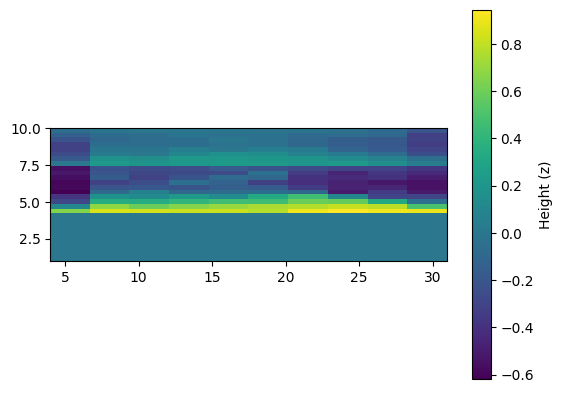

In [22]:
# Draw no aces case
_x = sorted(list(set([key[0] for key in no_aces_key])))
_y = sorted(list(set([key[1] for key in no_aces_key])))
print(_x)
print(_y)
Z = np.array([[v_values.get((__x, __y, 0), -0.6) for __y in _y] for __x in _x])

plt.imshow(Z, extent=(min(_x), max(_x), min(_y), max(_y)))
plt.colorbar(label='Height (z)')
plt.show()